In [3]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


class LSUNBedroomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        # Traverse the directory to get image paths
        for subdir, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith(('png', 'jpg', 'jpeg')):
                    self.image_paths.append(os.path.join(subdir, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

path = '../Dataset/bedroom/'
# Create dataset
dataset = LSUNBedroomDataset(root_dir='../Dataset/bedroom/', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


torch.Size([3, 64, 64])


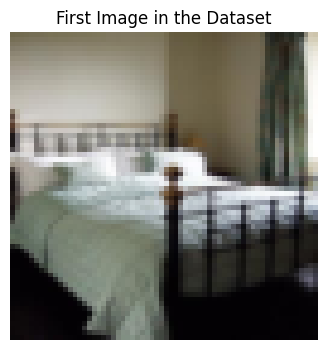

In [4]:
import matplotlib.pyplot as plt

image_tensor = dataset[0]
print(image_tensor.shape)
image = transforms.ToPILImage()(image_tensor)

# Display the image
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis('off')
plt.title("First Image in the Dataset")
plt.show()

In [5]:
model = UNet2DModel(
    sample_size=64,  # the target image resolution
    in_channels=3,    # the number of input channels, 3 for RGB images
    out_channels=3,   # the number of output channels
    layers_per_block=1,
    block_out_channels=(32, 64, 128),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D")
)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5
device = torch.device("cpu")
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, kernel_si

In [6]:
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()

        batch = batch.to(device)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch.size(0),), device=device).long()
        
        noisy_images = noise_scheduler.add_noise(batch, torch.randn_like(batch), timesteps)
        
        noise_pred = model(noisy_images, timesteps).sample
        
        loss = F.mse_loss(noise_pred, torch.randn_like(noise_pred))
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} completed. Loss: {loss.item()}")

Training Epoch 1/5:   0%|          | 0/18946 [00:00<?, ?it/s]

/Users/salveendutt/GithubRepos/Deep-Learning/.tfenv/lib/python3.11/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Training Epoch 1/5:   0%|          | 46/18946 [01:00<6:53:23,  1.31s/it]


KeyboardInterrupt: 

In [ ]:
# Save the model
torch.save(model.state_dict(), "ddpm_bedroom.pth")

NameError: name 'torch' is not defined

In [ ]:
# Load the model
model.load_state_dict(torch.load("ddpm_bedroom.pth"))
model.eval()